In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import xgboost
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from wwo_hist import retrieve_hist_data
from datetime import datetime, timedelta
from seffaflik.elektrik import uretim

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

today = datetime.today().strftime('%Y-%m-%d')
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
presentday = datetime.now()
tomorrow = (presentday + timedelta(1)).strftime('%Y-%m-%d')


start = pd.to_datetime('2021-01-01')
end = pd.to_datetime('2021-09-07')
rng = pd.date_range(start, end, freq='H')
len(rng)
rng = rng[0:-1]
len(rng)
rng = pd.DataFrame(rng)
rng = rng.set_axis(['DateTime'], axis=1)

def plottingresults(validation,prediction,label):
    x_ax = range(len(validation))
    plt.plot(x_ax, list(validation), linewidth=1.5, label="original")
    plt.plot(x_ax, list(prediction), linewidth=1.5, label="predicted")
    plt.title(label)
    plt.xlabel('Hours')
    plt.ylabel('MWh')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()
    

In [31]:
#%% Initialize XGBoostRegression

def XGBoostRegression(X_train,y_train,X_test):
    parameters_for_testing = {
    'colsample_bytree':[0.4],
    'gamma':[0,0.1,0.3],
    'min_child_weight':[10],
    'learning_rate':[0.01, 0.1, 0.2, 0.3],
    'max_depth':[3,5],
    'n_estimators':[200],
    'reg_alpha':[1e-5],
    'reg_lambda':[1e-5],
    'subsample':[0.6,0.95]  
    }
                    
    xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)
    
    gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,verbose=10,scoring='neg_mean_squared_error')
    gsearch1.fit(X_train,y_train)
    print (gsearch1.best_params_)
    print('best score')
    print (gsearch1.best_score_)
    Xgbpred = gsearch1.predict(X_test)

    return Xgbpred

In [32]:
#%% DATA PROCESSING

#Real Generation
Target = uretim.gerceklesen(baslangic_tarihi = '2021-01-01', bitis_tarihi = '2021-09-06', santral_id = "2382")
Target['DateTime'] = pd.to_datetime(Target.Tarih) + Target.Saat.astype('timedelta64[h]')
Target = Target.set_index('DateTime')
Target = pd.DataFrame(Target['Rüzgar'])

frequency=1
start_date = '01-JAN-2021'
end_date = '06-SEP-2021'
api_key = 'beb3f237e0274253b3764922210712'
location_list = ['41.173274,28.303366']
hist_weather_data = retrieve_hist_data(api_key, location_list,
                                        start_date, end_date, 
                                        frequency, location_label = False, 
                                        export_csv = False, store_df = True)
df = hist_weather_data[0]
df['hour'] = pd.DatetimeIndex(df['date_time']).hour
df['month'] = pd.DatetimeIndex(df['date_time']).month
df = df.set_index('date_time')



Retrieving weather data for 41.173274,28.303366


Currently retrieving data for 41.173274,28.303366: from 2021-01-01 to 2021-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.446277
Currently retrieving data for 41.173274,28.303366: from 2021-02-01 to 2021-02-28
Time elapsed (hh:mm:ss.ms) 0:00:02.616286
Currently retrieving data for 41.173274,28.303366: from 2021-03-01 to 2021-03-31
Time elapsed (hh:mm:ss.ms) 0:00:03.756729
Currently retrieving data for 41.173274,28.303366: from 2021-04-01 to 2021-04-30
Time elapsed (hh:mm:ss.ms) 0:00:04.968326
Currently retrieving data for 41.173274,28.303366: from 2021-05-01 to 2021-05-31
Time elapsed (hh:mm:ss.ms) 0:00:06.240259
Currently retrieving data for 41.173274,28.303366: from 2021-06-01 to 2021-06-30
Time elapsed (hh:mm:ss.ms) 0:00:07.497261
Currently retrieving data for 41.173274,28.303366: from 2021-07-01 to 2021-07-31
Time elapsed (hh:mm:ss.ms) 0:00:08.954697
Currently retrieving data for 41.173274,28.303366: from 2021-08-01 to 2021-08-31
Time e

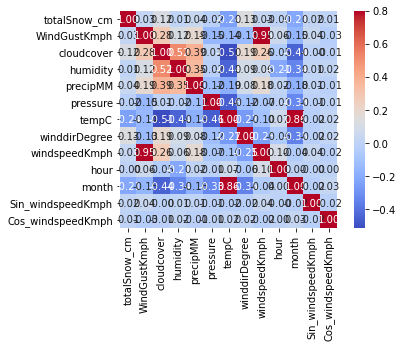

In [33]:
#%% Feature Elimination
eliminationfeature=["maxtempC","mintempC","sunHour","uvIndex",
                    "moon_illumination","moonrise","moonset",
                    "sunrise","sunset","DewPointC","FeelsLikeC",
                    "HeatIndexC","WindChillC","visibility","location"]
for feature in eliminationfeature:
    df = df.drop(feature, axis = 1)

df = df.astype(float)

df['Sin_windspeedKmph'] = np.sin(df['windspeedKmph'])
df['Cos_windspeedKmph'] = np.cos(df['windspeedKmph'])

df.index = df.index.rename('DateTime')
df = pd.merge(df, rng, on="DateTime", how="outer")

"Correlation matrix"
import seaborn as sns
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, vmax=.8, square=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.show()

In [34]:
#%% CUT-OFF AND INCORRECT VALUES

Target = pd.merge(Target, rng, on="DateTime", how="outer")

Target = Target.sort_values(by='DateTime', ascending=True)

df = df.loc[(df['DateTime'] < "2021-01-01 08:00:00") | (df['DateTime'] > "2021-01-01 15:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-05 00:00:00") | (df['DateTime'] > "2021-01-05 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-06 18:00:00") | (df['DateTime'] > "2021-01-06 22:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-08 14:00:00") | (df['DateTime'] > "2021-01-09 09:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-10 03:00:00") | (df['DateTime'] > "2021-01-10 14:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-12 03:00:00") | (df['DateTime'] > "2021-01-13 14:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-15 00:00:00") | (df['DateTime'] > "2021-01-15 13:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-16 00:00:00") | (df['DateTime'] > "2021-01-16 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-24 18:00:00") | (df['DateTime'] > "2021-01-24 20:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-25 17:00:00") | (df['DateTime'] > "2021-01-26 02:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-26 09:00:00") | (df['DateTime'] > "2021-01-26 18:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-27 01:00:00") | (df['DateTime'] > "2021-01-27 03:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-30 11:00:00") | (df['DateTime'] > "2021-01-30 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-01-31 11:00:00") | (df['DateTime'] > "2021-01-31 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-02 03:00:00") | (df['DateTime'] > "2021-02-02 07:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-06 10:00:00") | (df['DateTime'] > "2021-02-06 13:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-07 19:00:00") | (df['DateTime'] > "2021-02-08 06:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-08 17:00:00") | (df['DateTime'] > "2021-02-08 19:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-09 08:00:00") | (df['DateTime'] > "2021-02-09 20:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-10 08:00:00") | (df['DateTime'] > "2021-02-10 16:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-11 17:00:00") | (df['DateTime'] > "2021-02-13 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-16 22:00:00") | (df['DateTime'] > "2021-02-17 01:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-19 07:00:00") | (df['DateTime'] > "2021-02-19 15:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-21 00:00:00") | (df['DateTime'] > "2021-02-21 16:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-24 05:00:00") | (df['DateTime'] > "2021-02-24 07:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-25 00:00:00") | (df['DateTime'] > "2021-02-25 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-27 19:00:00") | (df['DateTime'] > "2021-02-27 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-02-28 14:00:00") | (df['DateTime'] > "2021-02-28 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-03 12:00:00") | (df['DateTime'] > "2021-03-03 20:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-06 00:00:00") | (df['DateTime'] > "2021-03-06 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-07 17:00:00") | (df['DateTime'] > "2021-03-07 21:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-15 17:00:00") | (df['DateTime'] > "2021-03-16 20:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-17 10:00:00") | (df['DateTime'] > "2021-03-17 20:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-20 19:00:00") | (df['DateTime'] > "2021-03-21 01:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-22 07:00:00") | (df['DateTime'] > "2021-03-22 14:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-24 02:00:00") | (df['DateTime'] > "2021-03-24 10:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-29 04:00:00") | (df['DateTime'] > "2021-03-29 12:00:00")]
df = df.loc[(df['DateTime'] < "2021-03-30 05:00:00") | (df['DateTime'] > "2021-03-30 11:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-01 00:00:00") | (df['DateTime'] > "2021-04-01 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-04 00:00:00") | (df['DateTime'] > "2021-04-05 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-07 06:00:00") | (df['DateTime'] > "2021-04-07 08:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-07 17:00:00") | (df['DateTime'] > "2021-04-07 19:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-08 13:00:00") | (df['DateTime'] > "2021-04-08 15:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-14 00:00:00") | (df['DateTime'] > "2021-04-14 23:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-17 23:00:00") | (df['DateTime'] > "2021-04-20 19:00:00")]
df = df.loc[(df['DateTime'] < "2021-04-21 16:00:00") | (df['DateTime'] > "2021-04-21 17:00:00")]
df = df.loc[(df['DateTime'] < "2021-05-09 16:00:00") | (df['DateTime'] > "2021-05-10 08:00:00")]

Target = Target.loc[(Target['DateTime'] < "2021-01-01 08:00:00") | (Target['DateTime'] > "2021-01-01 15:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-05 00:00:00") | (Target['DateTime'] > "2021-01-05 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-06 18:00:00") | (Target['DateTime'] > "2021-01-06 22:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-08 14:00:00") | (Target['DateTime'] > "2021-01-09 09:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-10 03:00:00") | (Target['DateTime'] > "2021-01-10 14:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-12 03:00:00") | (Target['DateTime'] > "2021-01-13 14:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-15 00:00:00") | (Target['DateTime'] > "2021-01-15 13:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-16 00:00:00") | (Target['DateTime'] > "2021-01-16 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-24 18:00:00") | (Target['DateTime'] > "2021-01-24 20:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-25 17:00:00") | (Target['DateTime'] > "2021-01-26 02:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-26 09:00:00") | (Target['DateTime'] > "2021-01-26 18:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-27 01:00:00") | (Target['DateTime'] > "2021-01-27 03:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-30 11:00:00") | (Target['DateTime'] > "2021-01-30 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-01-31 11:00:00") | (Target['DateTime'] > "2021-01-31 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-02 03:00:00") | (Target['DateTime'] > "2021-02-02 07:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-06 10:00:00") | (Target['DateTime'] > "2021-02-06 13:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-07 19:00:00") | (Target['DateTime'] > "2021-02-08 06:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-08 17:00:00") | (Target['DateTime'] > "2021-02-08 19:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-09 08:00:00") | (Target['DateTime'] > "2021-02-09 20:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-10 08:00:00") | (Target['DateTime'] > "2021-02-10 16:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-11 17:00:00") | (Target['DateTime'] > "2021-02-13 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-16 22:00:00") | (Target['DateTime'] > "2021-02-17 01:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-19 07:00:00") | (Target['DateTime'] > "2021-02-19 15:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-21 00:00:00") | (Target['DateTime'] > "2021-02-21 16:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-24 05:00:00") | (Target['DateTime'] > "2021-02-24 07:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-25 00:00:00") | (Target['DateTime'] > "2021-02-25 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-27 19:00:00") | (Target['DateTime'] > "2021-02-27 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-02-28 14:00:00") | (Target['DateTime'] > "2021-02-28 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-03 12:00:00") | (Target['DateTime'] > "2021-03-03 20:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-06 00:00:00") | (Target['DateTime'] > "2021-03-06 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-07 17:00:00") | (Target['DateTime'] > "2021-03-07 21:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-15 17:00:00") | (Target['DateTime'] > "2021-03-16 20:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-17 10:00:00") | (Target['DateTime'] > "2021-03-17 20:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-20 19:00:00") | (Target['DateTime'] > "2021-03-21 01:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-22 07:00:00") | (Target['DateTime'] > "2021-03-22 14:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-24 02:00:00") | (Target['DateTime'] > "2021-03-24 10:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-29 04:00:00") | (Target['DateTime'] > "2021-03-29 12:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-03-30 05:00:00") | (Target['DateTime'] > "2021-03-30 11:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-01 00:00:00") | (Target['DateTime'] > "2021-04-01 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-04 00:00:00") | (Target['DateTime'] > "2021-04-05 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-07 06:00:00") | (Target['DateTime'] > "2021-04-07 08:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-07 17:00:00") | (Target['DateTime'] > "2021-04-07 19:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-08 13:00:00") | (Target['DateTime'] > "2021-04-08 15:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-14 00:00:00") | (Target['DateTime'] > "2021-04-14 23:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-17 23:00:00") | (Target['DateTime'] > "2021-04-20 19:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-04-21 16:00:00") | (Target['DateTime'] > "2021-04-21 17:00:00")]
Target = Target.loc[(Target['DateTime'] < "2021-05-09 16:00:00") | (Target['DateTime'] > "2021-05-10 08:00:00")]


df = df.set_index('DateTime')
Target = Target.set_index('DateTime')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 

{'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.95}
best score
-0.40202401101542795


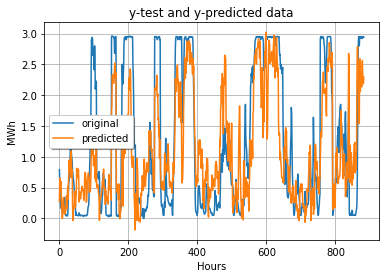

TRAIN: [   0    1    2 ... 1763 1764 1765] VALIDATION: [1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793
 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807
 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821
 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835
 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849
 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1

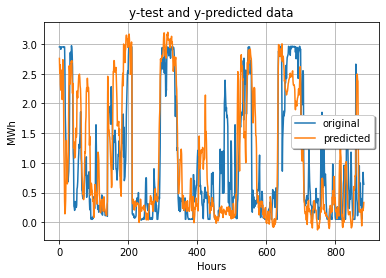

TRAIN: [   0    1    2 ... 2646 2647 2648] VALIDATION: [2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659 2660 2661 2662
 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676
 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687 2688 2689 2690
 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701 2702 2703 2704
 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715 2716 2717 2718
 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729 2730 2731 2732
 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743 2744 2745 2746
 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760
 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771 2772 2773 2774
 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785 2786 2787 2788
 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799 2800 2801 2802
 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813 2814 2815 2816
 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827 2828 2829 2830
 2831 2832 2833 2834 2

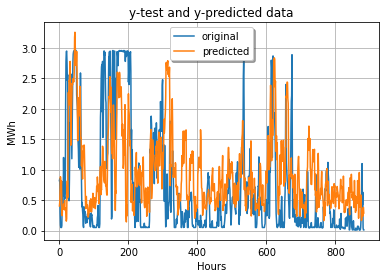

TRAIN: [   0    1    2 ... 3529 3530 3531] VALIDATION: [3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545
 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559
 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573
 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587
 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601
 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615
 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629
 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643
 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657
 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671
 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685
 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699
 3700 3701 3702 3703 3704 3705 3706 3707 3708 3709 3710 3711 3712 3713
 3714 3715 3716 3717 3

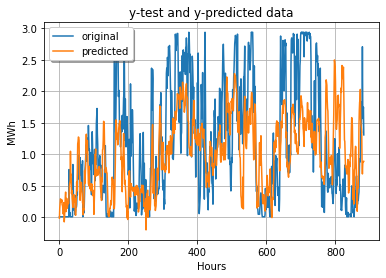

TRAIN: [   0    1    2 ... 4412 4413 4414] VALIDATION: [4415 4416 4417 4418 4419 4420 4421 4422 4423 4424 4425 4426 4427 4428
 4429 4430 4431 4432 4433 4434 4435 4436 4437 4438 4439 4440 4441 4442
 4443 4444 4445 4446 4447 4448 4449 4450 4451 4452 4453 4454 4455 4456
 4457 4458 4459 4460 4461 4462 4463 4464 4465 4466 4467 4468 4469 4470
 4471 4472 4473 4474 4475 4476 4477 4478 4479 4480 4481 4482 4483 4484
 4485 4486 4487 4488 4489 4490 4491 4492 4493 4494 4495 4496 4497 4498
 4499 4500 4501 4502 4503 4504 4505 4506 4507 4508 4509 4510 4511 4512
 4513 4514 4515 4516 4517 4518 4519 4520 4521 4522 4523 4524 4525 4526
 4527 4528 4529 4530 4531 4532 4533 4534 4535 4536 4537 4538 4539 4540
 4541 4542 4543 4544 4545 4546 4547 4548 4549 4550 4551 4552 4553 4554
 4555 4556 4557 4558 4559 4560 4561 4562 4563 4564 4565 4566 4567 4568
 4569 4570 4571 4572 4573 4574 4575 4576 4577 4578 4579 4580 4581 4582
 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593 4594 4595 4596
 4597 4598 4599 4600 4

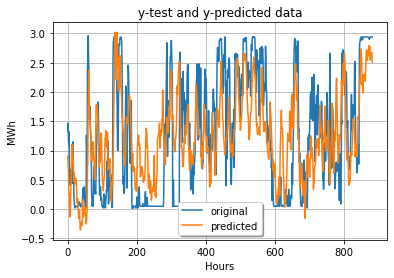

In [35]:
#%% TRAINING AND VALIDATION SET USING NESTED - CROSS VALIDATION

df = df.values
Target = Target.values

k = 0
n_splits=5

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
Xgbpred = pd.DataFrame(columns=np.arange(0,n_splits,1)).fillna(0)
maevalues = np.zeros(n_splits)
X_train_append = []
y_train_append = []
X_val_append = []
y_val_append = []
print(tscv)
for train_index, val_index in tscv.split(df):
    print("TRAIN:", train_index, "VALIDATION:", val_index)    
    X_train, X_val = df[train_index], df[val_index]
    y_train, y_val = Target[train_index], Target[val_index]
    X_train_append.append(X_train), y_train_append.append(y_train), X_val_append.append(X_val), y_val_append.append(y_val)
    Xgbpred[k] = XGBoostRegression(X_train,y_train,X_val)
    maevalues[k] = mean_absolute_error(y_val, Xgbpred[k])
    plottingresults(y_val,Xgbpred[k],"y-test and y-predicted data")
    k = k + 1
maevalues = list(maevalues)


In [36]:
#%% TEST SET

api_key = 'beb3f237e0274253b3764922210712'
location_list = ['41.1732740,28.3033660']
start_date = today
end_date = tomorrow
hist_weather_data2 = retrieve_hist_data(api_key, location_list,
                                        start_date, end_date, 
                                        frequency, location_label = False, 
                                        export_csv = False, store_df = True)
X_test = hist_weather_data2[0]
X_test = X_test[24:]
X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month
X_test = X_test.set_index('date_time')

for feature in eliminationfeature:
    X_test = X_test.drop(feature, axis = 1)

X_test = X_test.astype(float)

X_test['Sin_windspeedKmph'] = np.sin(X_test['windspeedKmph'])
X_test['Cos_windspeedKmph'] = np.cos(X_test['windspeedKmph'])
X_test = X_test.values



Retrieving weather data for 41.1732740,28.3033660


Currently retrieving data for 41.1732740,28.3033660: from 2022-01-28 to 2022-01-29
Time elapsed (hh:mm:ss.ms) 0:00:00.717043


<ipython-input-36-dd2b66141bd8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
<ipython-input-36-dd2b66141bd8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-0.35375551476252803


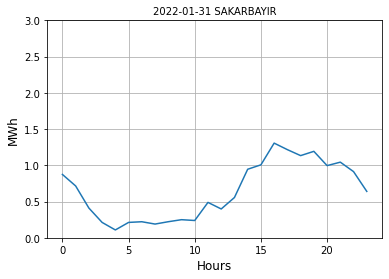

In [37]:
#%% PREDICTIONS

result = XGBoostRegression(X_train_append[maevalues.index(min(list(maevalues)))],
                           y_train_append[maevalues.index(min(list(maevalues)))],X_test)


installedcapacity=3
for ij in range(len(result)):
    if result[ij] > installedcapacity:
        result[ij]=installedcapacity
    elif result[ij] < 0:
        result[ij]=0

x = range(len(result))
ax = plt.figure().add_subplot(111)
ax.plot(x, list(result), linewidth=1.5)
ax.set_ylim(0, 3)
ax.set_title("{} SAKARBAYIR".format(tomorrow), fontsize=10)
ax.set_xlabel('Hours', fontsize=12)
ax.set_ylabel('MWh', fontsize=12)
ax.grid(True)
